In [1]:
import chainer
from chainer import Link, Chain, ChainList, Variable, optimizers, iterators
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import initializers
from chainer import serializers

import os
import time, datetime
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import coordinate
import data
from model import oplus, Generator
import xp_settings as settings
settings.set_gpu(0)
xp = settings.xp


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def plot_path(cart_path,target,xlim=[-5,5],ylim=[-5,5]):
    fig = plt.figure()
    path = cart_path
    target = target
    if(settings.gpu_index >= 0):
        path = xp.asnumpy(path)
        target = xp.asnumpy(target)
    plt.scatter(target[:,0],target[:,1],c="red",s=80,marker="o")
    for i in range(1,len(path)):
        plt.quiver(path[i-1,0],path[i-1,1]
                   , path[i,0]-path[i-1,0],path[i,1]-path[i-1,1]
                   , scale_units='xy', angles='xy', scale=1,color="blue")
    num_step = len(target)
    #plt.scatter(t[num_step-1,0],t[num_step-1,1],c="yellow",s=500,marker="*")
    plt.xlabel("x[m]")
    plt.ylabel("y[m]")
    plt.axis('scaled')
    plt.xlim(xlim[0],xlim[1])
    plt.ylim(ylim[0],ylim[1])
    plt.grid()
    plt.show()
    return fig

In [3]:
print('Sample 1 : check Oplus')
sample_x1 = Variable(xp.array([1, 1, 1], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 2, 0], dtype = 'float32'))
print(sample_x1.shape)
sample_z = oplus(sample_x1,sample_x2)
print(sample_z)
sample_z = sample_z * xp.array([1., 1., 0], dtype='float32')
sample_zt = F.transpose(sample_z)
print(sample_zt)
sample_e = F.matmul(sample_z, sample_zt)
print(sample_e)
print(sample_e.shape)
sample_e.backward()

Sample 1 : check Oplus
(3,)
variable([-0.14263964  2.9220755   1.0000002 ])
variable([-0.14263964  2.9220755   0.        ])
variable(8.558871)
()


Sample 2 : plot Oplus
variable([1.8660254 0.5       1.0471976])
variable([2.3660254 1.3660254 1.5707963])
variable([2.3660254 2.3660254 2.094395 ])
[[1.        0.        0.5235988]
 [1.8660254 0.5       1.0471976]
 [2.3660254 1.3660254 1.5707963]
 [2.3660254 2.3660254 2.094395 ]]


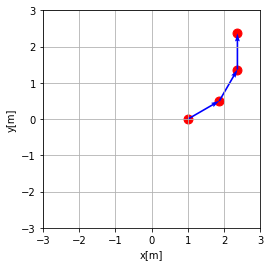

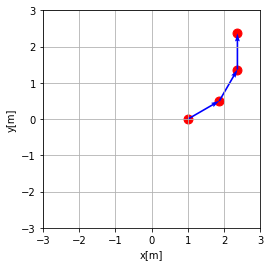

In [4]:
print('Sample 2 : plot Oplus')
sample_x1 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x3 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x4 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_z1 = oplus(sample_x1,sample_x2)
print(sample_z1)
sample_z2 = oplus(sample_z1,sample_x3)
print(sample_z2)
sample_z3 = oplus(sample_z2,sample_x4)
print(sample_z3)
sample_z = sample_z3 * xp.array([1., 1., 0], dtype='float32')
sample_pathes = xp.array(xp.vstack((sample_x1.data,sample_z1.data,sample_z2.data,sample_z3.data)),dtype='float32')
print(sample_pathes)
plot_path(sample_pathes,sample_pathes,[-3,3],[-3,3])

In [5]:
# dataset
DATA_SIZE = 1000
DATA_NUM_WAYPOINTS = 10
DATA_NUM_STEP = DATA_NUM_WAYPOINTS
DATA_HZ = 10
DATA_MAX_TRANS_VEL = 0.5 # [m/s]
DATA_MAX_ROTATE_VEL = 2*xp.pi # [rad/s]
DATA_M_PER_STEP = DATA_MAX_TRANS_VEL / DATA_HZ # [m/step]
DATA_RAD_PER_STEP = DATA_MAX_ROTATE_VEL / DATA_HZ # [rad/step]

print('DATA_SIZE          :',DATA_SIZE)
print('DATA_NUM_WAYPOINTS :',DATA_NUM_WAYPOINTS)
print('DATA_NUM_STEP      :',DATA_NUM_STEP)
print('DATA_HZ            :',DATA_HZ) 
print('DATA_MAX_TRANS_VEL :',DATA_MAX_TRANS_VEL)
print('DATA_MAX_ROTATE_VEL:',DATA_MAX_ROTATE_VEL)
print('DATA_M_PER_STEP    :',DATA_M_PER_STEP)
print('DATA_RAD_PER_STEP  :', DATA_RAD_PER_STEP)

X_train = []
for i in range(DATA_SIZE):
    l = int(DATA_NUM_WAYPOINTS*DATA_M_PER_STEP)+1 # line length
    rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
    d = data.make_arc_path_2(l,rand_rad,s=DATA_M_PER_STEP) 
    d_es,_ = data.get_evenly_spaced_points(d,DATA_M_PER_STEP)
    d_xy = d_es[0:DATA_NUM_WAYPOINTS]
    #d_xy_fl = xp.ravel(d_xy[0:DATA_WAYPOINTS])
    X_train.append(d_xy)
print(len(X_train))
print(X_train[0].shape)

DATA_SIZE          : 1000
DATA_NUM_WAYPOINTS : 10
DATA_NUM_STEP      : 10
DATA_HZ            : 10
DATA_MAX_TRANS_VEL : 0.5
DATA_MAX_ROTATE_VEL: 6.283185307179586
DATA_M_PER_STEP    : 0.05
DATA_RAD_PER_STEP  : 0.6283185307179586
1000
(10, 3)


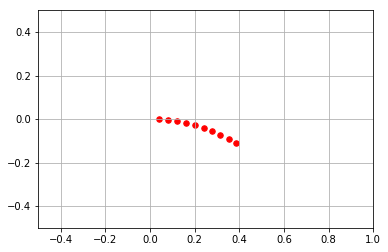

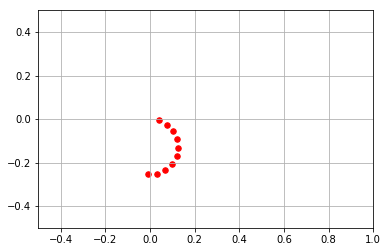

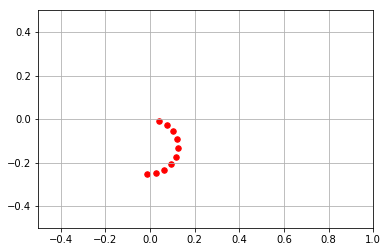

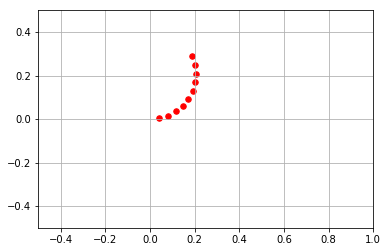

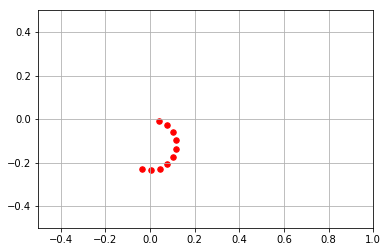

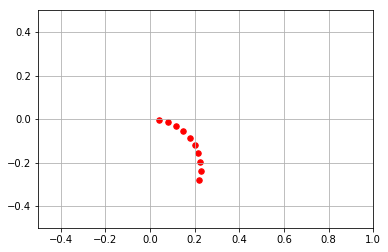

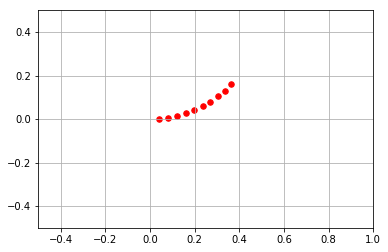

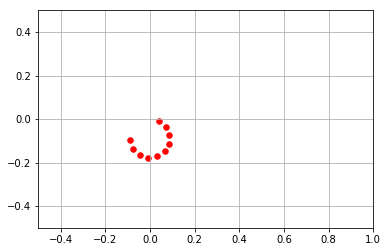

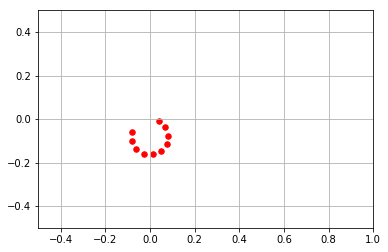

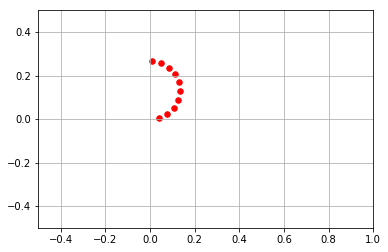

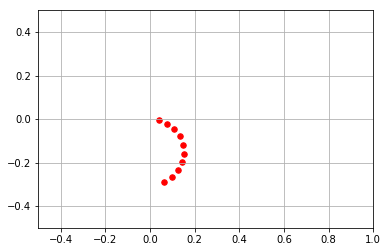

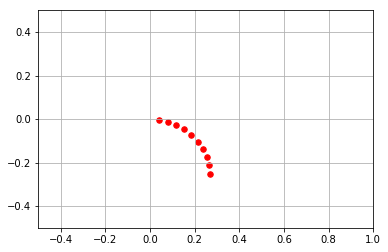

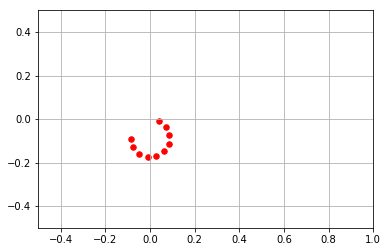

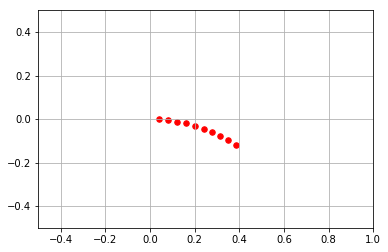

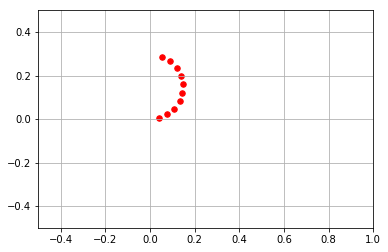

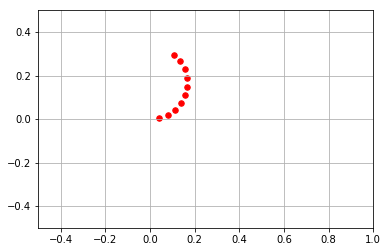

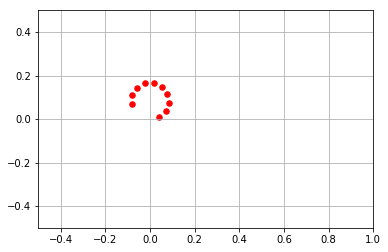

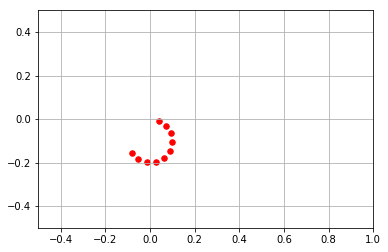

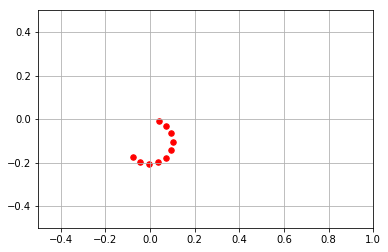

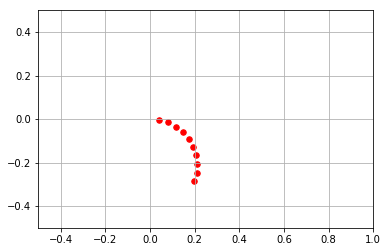

In [6]:
# plot data
p = X_train
random.shuffle(p)
if(settings.gpu_index >= 0):
    p = xp.asnumpy(p)

for num in range(20):
    rand_idx = int(np.random.rand() * len(X_train))
    plt.scatter(p[rand_idx][:,0], p[rand_idx][:,1],c="red",edgecolor="red",s=30,marker="o")
    plt.xlim([-.5,1])
    plt.ylim([-.5,.5])
    plt.grid()
    plt.show()
    print(' -- x_train -- ')
    print(p)


In [7]:
# loss
def error_squares(z_oplus,z_true):
    #print(predict)
    #print(groundtruth)
    w = xp.array([1., 1., 0.],dtype=xp.float32)
    t = z_true * w
    p = z_oplus * w
    error = F.sqrt(F.sum((t-p)*(t-p)))
    return error

def error_different_of_velocity(predict):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    p = predict * w
    error = F.sum(F.absolute(p))
    return error

def error_limit_rotate_vel(predict,limit):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    p = predict * w
    vel = F.sum(F.absolute(p))
    if vel.data < limit:
        error = vel * .0
    else:
        error = (vel - limit) / limit
    return error

def error_limit_trans_vel(predict,limit):
    w = xp.array([1., 0., 0.],dtype=xp.float32)
    p = predict * w
    vel = F.sum(F.absolute(p))
    if vel.data <= limit:
        error = vel * .0
    else:
        error = (vel - limit) / limit
    return error

def loss_function(y, y_true,dmesg=0):
    z_true = y_true
    z = y[0,0]
    e_distance = error_squares(z,z_true[0])
    e_lim_w = error_limit_rotate_vel(y[0,0], DATA_RAD_PER_STEP)
    e_lim_v = error_limit_trans_vel(y[0,0], DATA_M_PER_STEP)
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y[0,step])
        e_distance = e_distance + error_squares(z,z_true[step])
        e_lim_w = e_lim_w + error_limit_rotate_vel(y[0,step] , DATA_RAD_PER_STEP)
        e_lim_v = e_lim_v + error_limit_trans_vel(y[0,step], DATA_M_PER_STEP)
    loss = (10 * e_distance) + (1 * e_lim_w) + (1 * e_lim_v)
    if(dmesg):
        print('e_distance: ' + str(e_distance) + '\t e_lim_w: '  + str(e_lim_w) + '\t e_lim_v: '  + str(e_lim_v))
    return loss

In [8]:
# training
def train(model,X,epoch=10):
    if settings.gpu_index >= 0:
        cuda.cupy.cuda.Device(settings.gpu_index).use()
        model.to_gpu(settings.gpu_index)
    opt = optimizers.Adam()
    opt.setup(model)
    ep = 0
    AvgLoss = []
    while ep < epoch:
        random.shuffle(X)
        L = .0
        for itr in range(len(X)):
            x = xp.ravel(X[itr][:,0:2])
            x = Variable(xp.array([x],dtype=xp.float32))
            y = model(x)
            # zero-padding
            pad = Variable(xp.zeros((1,DATA_NUM_WAYPOINTS,1),dtype=xp.float32))
            y_pad = F.concat((y,pad),axis=2)
            y_pad = F.permutate(y_pad, xp.array([0,2,1],'i'), axis=2)
            # loss
            loss = loss_function(y_pad, X[itr][:])
            model.cleargrads()
            loss.backward()
            opt.update()
            # y_grad = chainer.grad( (e,), (y,) )[0]
            # print(y_grad)
            # x_grad = chainer.grad( (e,), (x,) )[0]
            # print(x_grad)
            L = L + loss.data
        ep = ep + 1
        print('Epoch:',ep,', Average loss:',L / len(X))
        AvgLoss.append(L / len(X))
    fig = plt.figure()
    plt.plot(range(len(AvgLoss)),AvgLoss)
    plt.xlabel('Epoch')
    plt.ylabel('Average loss (squares*10, lim_v, lim_w, )')
    plt.text(len(AvgLoss)-1, AvgLoss[-1],str(AvgLoss[-1]),ha='center',va='top' )
    return model, fig

Epoch: 1 , Average loss: 10.6600685
Epoch: 2 , Average loss: 5.8529625
Epoch: 3 , Average loss: 4.4562564
Epoch: 4 , Average loss: 3.6280608
Epoch: 5 , Average loss: 2.9828486
Epoch: 6 , Average loss: 2.6678245
Epoch: 7 , Average loss: 2.4289844
Epoch: 8 , Average loss: 2.2547991
Epoch: 9 , Average loss: 2.1071274
Epoch: 10 , Average loss: 1.9659994
Epoch: 11 , Average loss: 1.8596783
Epoch: 12 , Average loss: 1.6754555
Epoch: 13 , Average loss: 1.5687745
Epoch: 14 , Average loss: 1.4857607
Epoch: 15 , Average loss: 1.3567947
Epoch: 16 , Average loss: 1.266634
Epoch: 17 , Average loss: 1.1701438
Epoch: 18 , Average loss: 1.1631671
Epoch: 19 , Average loss: 1.0144911
Epoch: 20 , Average loss: 0.9983073
Epoch: 21 , Average loss: 0.92238027
Epoch: 22 , Average loss: 0.89759934
Epoch: 23 , Average loss: 0.84876144
Epoch: 24 , Average loss: 0.7932354
Epoch: 25 , Average loss: 0.7257099
Epoch: 26 , Average loss: 0.6750206
Epoch: 27 , Average loss: 0.6786071
Epoch: 28 , Average loss: 0.606202

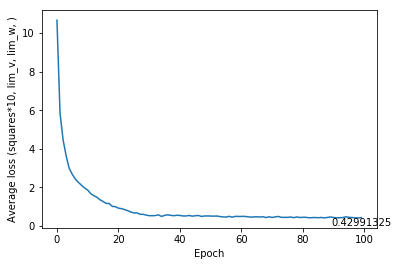

In [9]:
EPOCH = 100
model = Generator(DATA_NUM_WAYPOINTS,DATA_NUM_STEP)
start_time = '{0:%Y/%m/%d %H:%M:%S}'.format(datetime.datetime.now())
model, fig = train(model,X_train,epoch=EPOCH)
finish_time = '{0:%Y/%m/%d %H:%M:%S}'.format(datetime.datetime.now())
print('start:',start_time)
print('finish:',finish_time)

In [10]:
# log
def gen_filename():
    name_date = '{0:%Y%m%d%H%M%S}'.format(datetime.datetime.now())
    name_epoch = '{}epoch'.format(EPOCH)
    name_datasize  = '{}data'.format(DATA_SIZE)
    name_num_step = '{}step'.format(DATA_NUM_WAYPOINTS)
    name_space = '{}mm'.format(int(DATA_M_PER_STEP * 1000))
    fn = 'Cart' + name_space + name_num_step + '_' + name_date + '_'   + name_datasize + name_epoch
    return fn
dirname = gen_filename()
os.mkdir(dirname)
serializers.save_npz(dirname +'/'+ dirname+'.model', model)
fig.savefig(dirname + '/' + 'loss.png')

 --- input --- 
[[ 4.08145133e-02  3.33187101e-04 -1.55446980e+00]
 [ 8.16181474e-02  1.33265959e-03 -1.53814327e+00]
 [ 1.22400026e-01  2.99815107e-03 -1.52181673e+00]
 [ 1.63149279e-01  5.32921759e-03 -1.50549020e+00]
 [ 2.03855045e-01  8.32523781e-03 -1.48916367e+00]
 [ 2.44506474e-01  1.19854131e-02 -1.47283714e+00]
 [ 2.85092729e-01  1.63087680e-02 -1.45651061e+00]
 [ 3.25602992e-01  2.12941499e-02 -1.44018408e+00]
 [ 3.66026467e-01  2.69402301e-02 -1.42385755e+00]
 [ 4.06352377e-01  3.32455036e-02 -1.40753102e+00]]
 --- output --- 
[[[ 0.04028409  0.          0.02648863]
  [ 0.04085844  0.          0.03884043]
  [ 0.03900066  0.          0.00094674]
  [ 0.04110309  0.          0.02669986]
  [ 0.04171174  0.          0.00268437]
  [ 0.04037113  0.          0.04822297]
  [ 0.03951425  0.          0.01330015]
  [ 0.04085058  0.         -0.00097603]
  [ 0.03892511  0.          0.04779404]
  [ 0.03843802  0.         -0.01282499]]]
[[ 1.517687    2.2253926   0.05424449  1.5297891   0.1

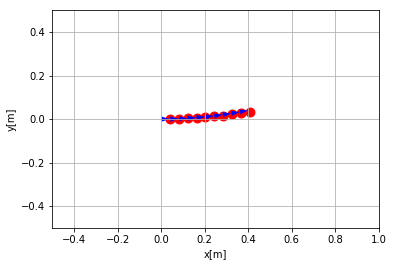

 --- grad --- 
variable([[[-75.266754    13.156392  ]
           [-65.519905    11.147999  ]
           [-54.379852     8.978651  ]
           [-44.859528     6.822566  ]
           [-34.903854     4.8024435 ]
           [-30.047369     3.1992455 ]
           [-22.899698     1.9122207 ]
           [-16.865675     0.9078233 ]
           [-12.522162     0.30157265]
           [ -6.2004204    0.        ]]])


In [14]:
x_path = data.make_arc_path_2(int(DATA_NUM_WAYPOINTS*DATA_M_PER_STEP+1),xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP,s=DATA_M_PER_STEP)
x_path = data.make_arc_path_2(int(DATA_NUM_WAYPOINTS*DATA_M_PER_STEP+1),0.02,s=DATA_M_PER_STEP)
x_path_es,_ = data.get_evenly_spaced_points(x_path,DATA_M_PER_STEP)
x_test = x_path_es[0:DATA_NUM_WAYPOINTS]
x = xp.ravel(x_test[:,0:2])
x = Variable(xp.array([x],dtype=xp.float32))
y = model(x)
# zero-padding
pad = Variable(xp.zeros((1,DATA_NUM_WAYPOINTS,1),dtype=xp.float32))
y_pad = F.concat((y,pad),axis=2)
y_pad = F.permutate(y_pad, xp.array([0,2,1],'i'), axis=2)
print(' --- input --- ')
print(x_test)
print(' --- output --- ')
print(y_pad.data)
print(xp.rad2deg(y_pad.data[:,:,2]))
# loss
z_true = x_test
z = y_pad[0,0]
print(' --- error --- ')
Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
for step in range(1,DATA_NUM_STEP):
    z = oplus(z,y_pad[0,step])
    Z = xp.vstack((Z,z.data))
loss = loss_function(y_pad, x_test, dmesg=1)
print('loss:',loss)
print(' --- trajectory --- ')
print(Z)
print(z_true.shape)
fig = plot_path(Z,z_true,[-.5,1],[-.5,.5])
print(' --- grad --- ')
loss.backward()
y_grad = chainer.grad( (loss,), (y,) )[0]
print(y_grad)

 --- input --- 
[[ 3.94042974e-02 -9.18454625e-03 -2.02878893e+00]
 [ 7.06867285e-02 -3.48451007e-02 -2.48678154e+00]
 [ 8.73994755e-02 -7.16926058e-02 -2.94477414e+00]
 [ 8.60977695e-02 -1.12132192e-01 -3.40276675e+00]
 [ 6.70499134e-02 -1.47828602e-01 -3.86075936e+00]
 [ 3.41819799e-02 -1.71424227e-01 -4.31875196e+00]
 [-5.73141542e-03 -1.78055623e-01 -4.77674457e+00]
 [-4.44634728e-02 -1.66355953e-01 -5.23473717e+00]
 [-7.40308855e-02 -1.38736709e-01 -5.69272978e+00]
 [-8.83393290e-02 -1.00890666e-01 -6.15072239e+00]]
 --- output --- 
[[[ 0.03122681  0.         -0.6286238 ]
  [ 0.04806221  0.         -0.55341595]
  [ 0.0458721   0.         -0.42554903]
  [ 0.04075659  0.         -0.48018813]
  [ 0.03904824  0.         -0.42283165]
  [ 0.0393191   0.         -0.47704306]
  [ 0.0399507   0.         -0.45334095]
  [ 0.03839756  0.         -0.43903583]
  [ 0.04027935  0.         -0.47512996]
  [ 0.03942749  0.          0.06327637]]]
 --- error --- 
loss: variable(0.01229744)
loss: varia

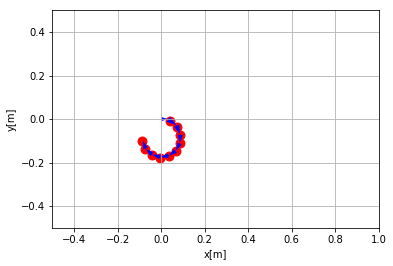

 --- input --- 
[[ 0.04052246 -0.00423097 -1.77886338]
 [ 0.07929695 -0.01674137 -1.98693044]
 [ 0.11465088 -0.03699156 -2.1949975 ]
 [ 0.14505925 -0.06410802 -2.40306456]
 [ 0.16921034 -0.09692105 -2.61113162]
 [ 0.18606239 -0.13401525 -2.81919868]
 [ 0.19488846 -0.17379051 -3.02726573]
 [ 0.19530784 -0.21453109 -3.23533279]
 [ 0.18730242 -0.25447961 -3.44339985]
 [ 0.17121754 -0.29191285 -3.65146691]]
 --- output --- 
[[[ 0.03894644  0.         -0.35920104]
  [ 0.04310557  0.         -0.19844256]
  [ 0.03914525  0.         -0.18280853]
  [ 0.04046761  0.         -0.20182289]
  [ 0.04078688  0.         -0.19427744]
  [ 0.03981327  0.         -0.21893989]
  [ 0.03960837  0.         -0.19411044]
  [ 0.04042184  0.         -0.21780688]
  [ 0.03926031  0.         -0.1963419 ]
  [ 0.03847576  0.          0.09412264]]]
 --- error --- 
loss: variable(0.00451497)
loss: variable(0.00158863)
loss: variable(0.00241265)
loss: variable(0.00283213)
loss: variable(0.0029421)
loss: variable(0.0034177

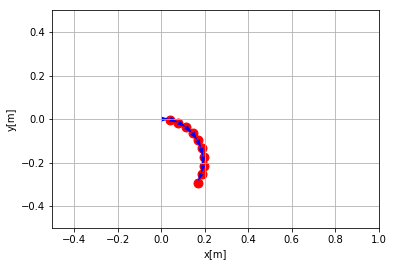

 --- input --- 
[[ 0.03908996  0.0101274  -1.06378517]
 [ 0.06834485  0.03796155 -0.55677401]
 [ 0.08040415  0.07649936 -0.04976285]
 [ 0.0722337   0.11604468  0.45724831]
 [ 0.04588922  0.1466479   0.96425947]
 [ 0.00799898  0.16060923  1.47127063]
 [-0.03190381  0.15441597  1.97828179]
 [-0.06377958  0.12962637  2.48529295]
 [-0.07960837  0.09247751  2.99230411]
 [-0.07540764  0.05231605  3.49931527]]
 --- output --- 
[[[ 0.03160566  0.          0.740499  ]
  [ 0.04975534  0.          0.56282455]
  [ 0.04122586  0.          0.4324432 ]
  [ 0.04176308  0.          0.509876  ]
  [ 0.04289212  0.          0.51270217]
  [ 0.04101576  0.          0.5011461 ]
  [ 0.03947996  0.          0.4952575 ]
  [ 0.04093407  0.          0.54600394]
  [ 0.03810211  0.          0.47173762]
  [ 0.03685517  0.         -0.5442685 ]]]
 --- error --- 
loss: variable(0.01259281)
loss: variable(0.00439382)
loss: variable(0.0033829)
loss: variable(0.00152692)
loss: variable(0.00140273)
loss: variable(0.0027817

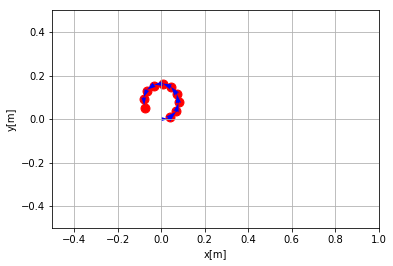

 --- input --- 
[[ 0.04059547 -0.00367024 -1.75112625]
 [ 0.07987439 -0.01456193 -1.93145617]
 [ 0.11656292 -0.03232185 -2.11178609]
 [ 0.14947121 -0.05637402 -2.29211602]
 [ 0.17753203 -0.08593842 -2.47244594]
 [ 0.19983533 -0.12005624 -2.65277586]
 [ 0.2156578  -0.15762101 -2.83310578]
 [ 0.2244863  -0.19741448 -3.01343571]
 [ 0.22603452 -0.23814611 -3.19376563]
 [ 0.22025225 -0.27849494 -3.37409555]]
 --- output --- 
[[[ 0.03952241  0.         -0.31383532]
  [ 0.04234793  0.         -0.17011367]
  [ 0.03937742  0.         -0.16076092]
  [ 0.04041286  0.         -0.17409141]
  [ 0.04065887  0.         -0.17309766]
  [ 0.0399351   0.         -0.18299499]
  [ 0.039812    0.         -0.17023356]
  [ 0.040321    0.         -0.19432333]
  [ 0.0395191   0.         -0.16307715]
  [ 0.03882491  0.          0.08986358]]]
 --- error --- 
loss: variable(0.00382389)
loss: variable(0.00149051)
loss: variable(0.00211912)
loss: variable(0.00260653)
loss: variable(0.00285568)
loss: variable(0.003487

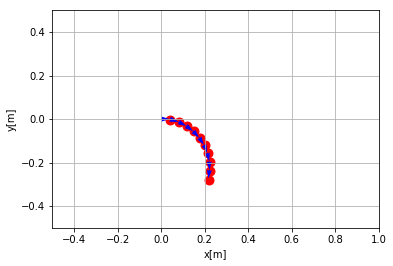

 --- input --- 
[[ 0.039933   -0.00729804 -1.93232066]
 [ 0.07470337 -0.02824864 -2.293845  ]
 [ 0.0998159  -0.06014327 -2.65536934]
 [ 0.11202398 -0.0988585  -3.01689368]
 [ 0.10974932 -0.13938913 -3.37841801]
 [ 0.09328599 -0.17649526 -3.73994235]
 [ 0.06476242 -0.20537972 -4.10146669]
 [ 0.0278662  -0.22230826 -4.46299103]
 [-0.01263263 -0.2250923  -4.82451536]
 [-0.05149828 -0.21337192 -5.1860397 ]]
 --- output --- 
[[[ 0.035929    0.         -0.59625995]
  [ 0.04723801  0.         -0.36116195]
  [ 0.04024574  0.         -0.31158707]
  [ 0.03957253  0.         -0.3659768 ]
  [ 0.03945429  0.         -0.32123372]
  [ 0.03932159  0.         -0.42525613]
  [ 0.04007672  0.         -0.33781388]
  [ 0.0396313   0.         -0.35699806]
  [ 0.04000337  0.         -0.38680857]
  [ 0.03874965  0.          0.11310685]]]
 --- error --- 
loss: variable(0.00832427)
loss: variable(0.00175015)
loss: variable(0.00178011)
loss: variable(0.00264748)
loss: variable(0.00364328)
loss: variable(0.003526

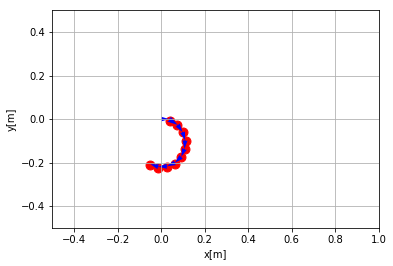

 --- input --- 
[[ 0.03914299  0.00997531 -1.07173352]
 [ 0.06873756  0.0374679  -0.57267071]
 [ 0.08156449  0.07577129 -0.0736079 ]
 [ 0.07449482  0.11554189  0.42545491]
 [ 0.04925311  0.14707816  0.92451772]
 [ 0.01199674  0.16268725  1.42358053]
 [-0.02818608  0.15856151  1.92264334]
 [-0.06149327  0.13570737  2.42170615]
 [-0.07979997  0.0996998   2.92076896]
 [-0.07864051  0.05932238  3.41983177]]
 --- output --- 
[[[ 0.0317681   0.          0.7347423 ]
  [ 0.04958716  0.          0.55722165]
  [ 0.04132658  0.          0.42729566]
  [ 0.04168932  0.          0.50426936]
  [ 0.04276406  0.          0.5067752 ]
  [ 0.04102132  0.          0.49598128]
  [ 0.03957186  0.          0.48953295]
  [ 0.04085888  0.          0.53987455]
  [ 0.03823791  0.          0.4669173 ]
  [ 0.03700786  0.         -0.5383929 ]]]
 --- error --- 
loss: variable(0.01240548)
loss: variable(0.00422851)
loss: variable(0.00323704)
loss: variable(0.00152154)
loss: variable(0.00182456)
loss: variable(0.002610

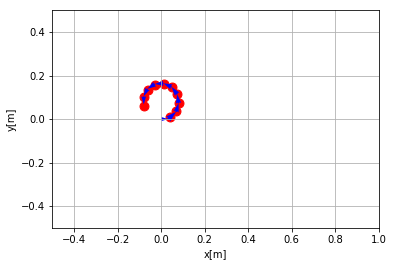

 --- input --- 
[[ 0.04051149  0.00430883 -1.35887161]
 [ 0.07921032  0.01704253 -1.14694689]
 [ 0.11436494  0.03763134 -0.93502218]
 [ 0.1444024   0.06515402 -0.72309746]
 [ 0.16797867  0.0983791  -0.51117275]
 [ 0.18403887  0.13581994 -0.29924803]
 [ 0.19186439  0.17580129 -0.08732332]
 [ 0.19110508  0.2165342   0.1246014 ]
 [ 0.18179491  0.25619611  0.33652612]
 [ 0.16435047  0.29301239  0.54845083]]
 --- output --- 
[[[ 0.03800949  0.          0.33500606]
  [ 0.04311518  0.          0.2408014 ]
  [ 0.04086626  0.          0.1592278 ]
  [ 0.04077994  0.          0.20792659]
  [ 0.04115343  0.          0.19055481]
  [ 0.04074266  0.          0.22286075]
  [ 0.04031141  0.          0.19095175]
  [ 0.04024706  0.          0.20366909]
  [ 0.03975008  0.          0.21077372]
  [ 0.03910002  0.         -0.20578879]]]
 --- error --- 
loss: variable(0.00498257)
loss: variable(0.00290765)
loss: variable(0.00181667)
loss: variable(0.00179376)
loss: variable(0.00141032)
loss: variable(0.001940

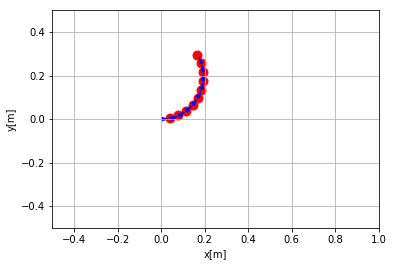

 --- input --- 
[[ 0.04060488 -0.00359147 -1.74723553]
 [ 0.07994898 -0.01425436 -1.92367473]
 [ 0.11681065 -0.03165758 -2.10011392]
 [ 0.15004533 -0.05526078 -2.27655312]
 [ 0.1786211  -0.08433105 -2.45299232]
 [ 0.20165065 -0.11796578 -2.62943152]
 [ 0.21841893 -0.15512058 -2.80587072]
 [ 0.22840528 -0.19464182 -2.98230992]
 [ 0.23129962 -0.23530234 -3.15874912]
 [ 0.22701208 -0.27583963 -3.33518832]]
 --- output --- 
[[[ 0.03960333  0.         -0.3073397 ]
  [ 0.0422415   0.         -0.16611013]
  [ 0.03941003  0.         -0.15765014]
  [ 0.04040517  0.         -0.17017227]
  [ 0.04064089  0.         -0.1701089 ]
  [ 0.03995221  0.         -0.17790344]
  [ 0.03984061  0.         -0.16686249]
  [ 0.04030684  0.         -0.19100566]
  [ 0.03955545  0.         -0.15837225]
  [ 0.03887397  0.          0.08926498]]]
 --- error --- 
loss: variable(0.00372851)
loss: variable(0.00147765)
loss: variable(0.00207951)
loss: variable(0.00257198)
loss: variable(0.00283505)
loss: variable(0.003483

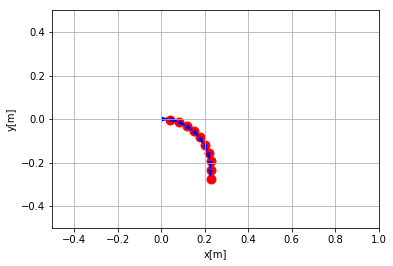

 --- input --- 
[[ 0.04063521  0.00332482 -1.40751781]
 [ 0.08018949  0.01321083 -1.24423929]
 [ 0.11761068  0.02939506 -1.08096077]
 [ 0.15190334  0.051447   -0.91768226]
 [ 0.18215527  0.07878005 -0.75440374]
 [ 0.20756174  0.11066713 -0.59112522]
 [ 0.22744692  0.14626002 -0.42784671]
 [ 0.24128185  0.18461194 -0.26456819]
 [ 0.24869852  0.22470268 -0.10128967]
 [ 0.24949964  0.26546581  0.06198885]]
 --- output --- 
[[[ 0.03906603  0.          0.25914446]
  [ 0.04201996  0.          0.18946399]
  [ 0.04147675  0.          0.11839111]
  [ 0.04031989  0.          0.1599436 ]
  [ 0.04035428  0.          0.13929082]
  [ 0.04077376  0.          0.17942056]
  [ 0.04088036  0.          0.1426324 ]
  [ 0.03978143  0.          0.14823687]
  [ 0.0405952   0.          0.17147288]
  [ 0.04005427  0.         -0.15271594]]]
 --- error --- 
loss: variable(0.00367651)
loss: variable(0.00249503)
loss: variable(0.0008459)
loss: variable(0.0013307)
loss: variable(0.00180932)
loss: variable(0.00237106

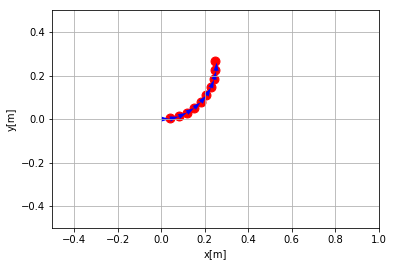

 --- input --- 
[[ 0.04031168 -0.00553435 -1.84366838]
 [ 0.07764037 -0.02172786 -2.11654044]
 [ 0.10922381 -0.04738225 -2.38941249]
 [ 0.13272486 -0.08059913 -2.66228455]
 [ 0.14640451 -0.11892051 -2.93515661]
 [ 0.14925047 -0.15951068 -3.20802866]
 [ 0.14105215 -0.19936602 -3.48090072]
 [ 0.12241622 -0.23553732 -3.75377277]
 [ 0.09472169 -0.26534795 -4.02664483]
 [ 0.06001792 -0.28659199 -4.29951689]]
 --- output --- 
[[[ 0.03782737  0.         -0.4625273 ]
  [ 0.04467296  0.         -0.26522732]
  [ 0.0400389   0.         -0.235223  ]
  [ 0.03988795  0.         -0.27017736]
  [ 0.03987285  0.         -0.24660969]
  [ 0.0396616   0.         -0.30572504]
  [ 0.04010377  0.         -0.25380424]
  [ 0.03985227  0.         -0.27541178]
  [ 0.03997571  0.         -0.2752819 ]
  [ 0.03901803  0.          0.10048602]]]
 --- error --- 
loss: variable(0.00606637)
loss: variable(0.00180195)
loss: variable(0.00172606)
loss: variable(0.00258692)
loss: variable(0.00336471)
loss: variable(0.003648

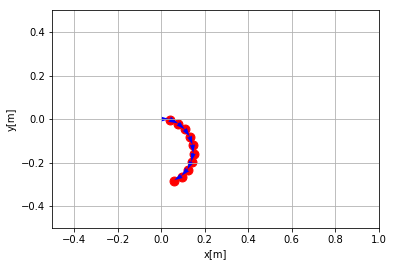

In [12]:
for i in range(10):
    x_path = data.make_arc_path_2(int(DATA_NUM_WAYPOINTS*DATA_M_PER_STEP+1),xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP,s=DATA_M_PER_STEP)
    x_path_es,_ = data.get_evenly_spaced_points(x_path,DATA_M_PER_STEP)
    x_test = x_path_es[0:DATA_NUM_WAYPOINTS]
    x = xp.ravel(x_test[:,0:2])
    x = Variable(xp.array([x],dtype=xp.float32))
    y = model(x)
    # zero-padding
    pad = Variable(xp.zeros((1,DATA_NUM_WAYPOINTS,1),dtype=xp.float32))
    y_pad = F.concat((y,pad),axis=2)
    y_pad = F.permutate(y_pad, xp.array([0,2,1],'i'), axis=2)
    print(' --- input --- ')
    print(x_test)
    print(' --- output --- ')
    print(y_pad.data)
    # loss
    z_true = x_test
    z = y_pad[0,0]
    e = error_squares(z,z_true[0])
    print(' --- error --- ')
    print('loss:',e)
    Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y_pad[0,step])
        e = error_squares(z,z_true[step])
        print('loss:',e)
        Z = xp.vstack((Z,z.data))
    print(' --- trajectory --- ')
    print(Z)
    print(z_true.shape)
    fig = plot_path(Z,z_true,[-.5,1],[-.5,.5])
    fig.savefig(dirname + '/test' + str(i) + '.png')